In [363]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

# load nr

In [364]:
catalogue_dir = "/Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022"

In [365]:
df = pd.read_csv(os.path.join(catalogue_dir, 'metadata.csv'))

In [366]:
times = np.load(os.path.join(catalogue_dir, 'times.npy'))

In [367]:
strains = np.load(os.path.join(catalogue_dir, 'strains.npy'))

In [368]:
df.query("q==1")

name    q     fring     fdamp  duration  t_final
18   SXS_BBH_0180_Res3  1.0  0.088087  0.013596    9359.5    236.6
20   SXS_BBH_0180_Res2  1.0  0.088087  0.013596    9354.6    236.8
22   SXS_BBH_0180_Res4  1.0  0.088087  0.013596    9270.5    236.4
27  RIT-eBBH-1090-n100  1.0  0.088087  0.013596    1493.9    362.0
31   RIT-BBH-0112-n100  1.0  0.088087  0.013596   16963.4    419.5

In [369]:
# idx = 22 # q1
# idx = 6 # q18
idx = 34 # q32

In [370]:
import pn

In [371]:
t = np.arange(-1000, -100, 1)
tc = 0
eta = phenom.eta_from_q(df['q'][idx])
M = 1

In [372]:
omega_pn = pn.TaylorT3_Omega_GW(t, tc, eta, M)

In [373]:
omega_N = pn.TaylorT3_Omega_GW_Newt(t, tc, eta, M)

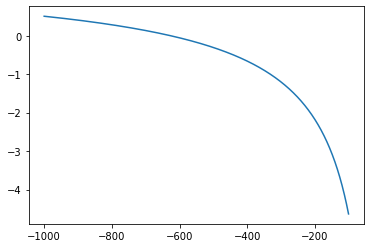

In [374]:
plt.plot(t, omega_pn/omega_N)

In [375]:
h22_pn = pn.TaylorT3_Hhat22(t, tc, eta, M)
h22_pn = np.abs(h22_pn)

/Users/sebastian.khan/personal/git/stk/ml/waveforms/oct2022/uncertainty/nr_only/scratch_2/pn.py:178: RuntimeWarning: invalid value encountered in power
  x = (M*OrgAngFreq)**(2./3)


In [376]:
x = pn.x_from_omega_22(omega_pn)

In [377]:
h22_pre = pn.Hhat22_pre_factor(x, eta)

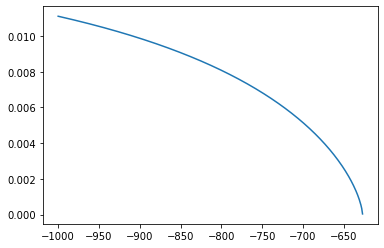

In [378]:
plt.plot(t, h22_pn)

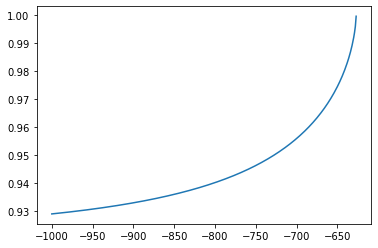

In [379]:
plt.plot(t, h22_pn/h22_pre)

In [380]:
nr_times = times.copy()
y = strains[idx]

In [381]:
amp=np.abs(y)
phase=np.unwrap(np.angle(y))
freq=IUS(nr_times, phase).derivative()(nr_times)

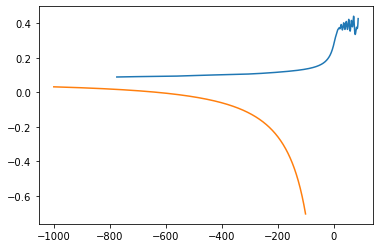

In [382]:
plt.plot(nr_times, freq)
plt.plot(t, omega_pn)

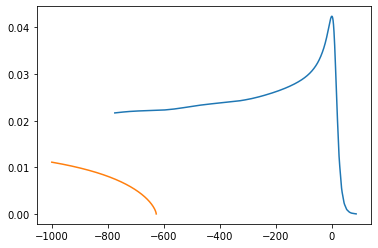

In [383]:
plt.plot(nr_times, amp)
plt.plot(t, h22_pn)

In [384]:
# interpolate onto common grid
common_times_start = max(nr_times[0], t[0])
common_times_end = min(nr_times[-1], t[-1])
common_times = np.arange(common_times_start, common_times_end, 1)

nr_freq_ = IUS(nr_times, freq)(common_times)
pn_freq_ = IUS(t, omega_pn)(common_times)

nr_amp_ = IUS(nr_times, amp)(common_times)
pn_amp_ = IUS(t, h22_pn)(common_times)

In [385]:
omega_N_ = pn.TaylorT3_Omega_GW_Newt(common_times, tc, eta, M)

In [386]:
x_ = pn.x_from_omega_22(pn_freq_)
h22_pre_ = pn.Hhat22_pre_factor(x_, eta)

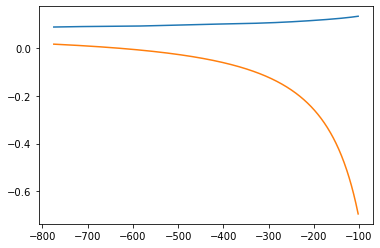

In [387]:
plt.plot(common_times, nr_freq_)
plt.plot(common_times, pn_freq_)

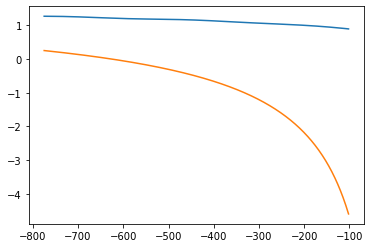

In [388]:
plt.plot(common_times, nr_freq_/omega_N_)
plt.plot(common_times, pn_freq_/omega_N_)

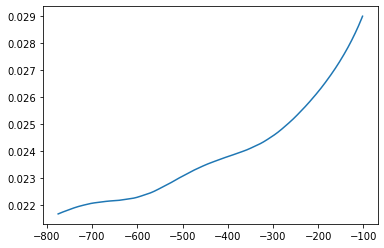

In [389]:
plt.plot(common_times, nr_amp_)
plt.plot(common_times, pn_amp_)

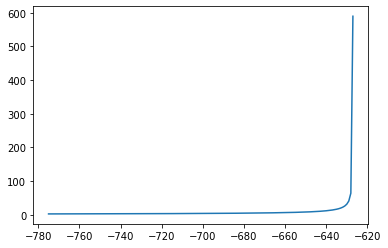

In [390]:
plt.plot(common_times, nr_amp_/h22_pre_)
plt.plot(common_times, pn_amp_/h22_pre_)

# test fits

In [391]:
os.sys.path.append("/Users/sebastian.khan/personal/git/stk/ml/waveforms/oct2022/uncertainty")

In [392]:
# custom module
import collocation as col

In [393]:
import sympy
# sympy.init_printing()
x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

In [394]:
# t_mask = (nr_times >= -700) & (nr_times <= -300)
t_mask = (nr_times >= -700) & (nr_times <= -200)
t_to_fit = nr_times[t_mask]
y_to_fit = freq[t_mask]

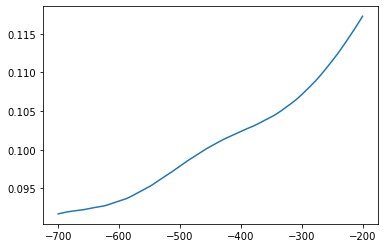

In [395]:
plt.plot(t_to_fit, y_to_fit)

In [396]:
omega_pn = pn.TaylorT3_Omega_GW(t_to_fit, tc, eta, M)

In [397]:
omega_N = pn.TaylorT3_Omega_GW_Newt(t_to_fit, tc, eta, M)

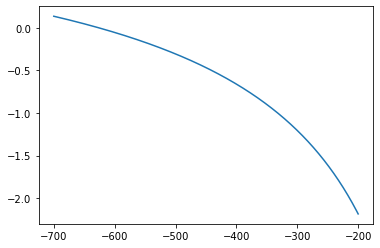

In [398]:
plt.plot(t_to_fit, omega_pn/omega_N)

In [399]:
# residuals_to_fit = (NR_DATA - PN_DATA) / NEWTONIAN_TERM

In [400]:
residuals_to_fit = (y_to_fit - omega_pn) / omega_N

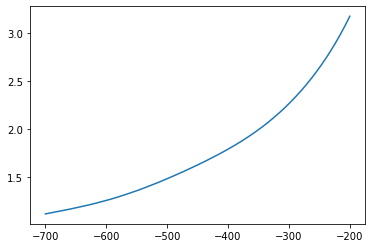

In [401]:
plt.plot(t_to_fit, residuals_to_fit)

In [402]:
# base_ansatz = np.sum([x_sym**8, x_sym**9, x_sym**10, x_sym**11])
base_ansatz = np.sum([x_sym**8, x_sym**9, x_sym**10])
collocation_points = {
    # 0:[-700, -500, -300],
    0:[-700, -500, -200],
    # 1:[-300]
}

In [403]:
pn_kwargs=dict(t=t_to_fit, tc=tc, eta=eta, M=M)
theta = pn.TaylorT3_theta(x_sym, pn_kwargs['tc'], pn_kwargs['eta'], pn_kwargs['M'])
pn_sub_dict = {'x_sym': theta }
ansatz = base_ansatz.subs(pn_sub_dict)
sub_dict=None

In [404]:
ansatz

614.553762930778/(-x_sym)**1.25 + 323.373102968831/(-x_sym)**1.125 + 170.15625/(-x_sym)**1.0

In [405]:
# collocation fit
# interpolate target so we can evaluate
# it and it's derivative at any x value
iy = IUS(t_to_fit, residuals_to_fit)

# evaluate interpolant at corresponding derivative order
# and location
rhs = {}
for k in collocation_points.keys():
    v = map(iy.derivative(k), collocation_points[k])
    v = np.array(list(v))
    rhs[k] = v

# change col.CollocationModel to take as input dictionaries for
# `collocation_points` and `rhs`
# with keys that are integer and represent the order of the derivative
cm = col.CollocationModelNew(
    collocation_points=collocation_points,
    rhs=rhs,
    ansatz=ansatz,
    sub_dict=sub_dict,
)

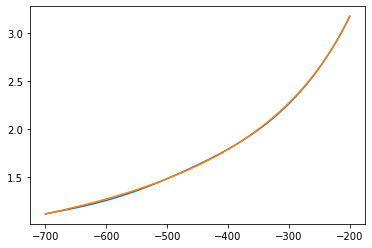

In [406]:
plt.plot(t_to_fit, residuals_to_fit)
plt.plot(t_to_fit, cm.predict(t_to_fit))

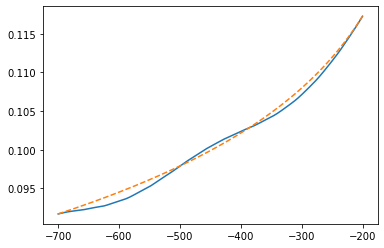

In [407]:
plt.plot(t_to_fit, y_to_fit)
plt.plot(t_to_fit, omega_pn + (omega_N*cm.predict(t_to_fit)), ls='--')

In [408]:
omega_pn_ = pn.TaylorT3_Omega_GW(t, tc, eta, M)

In [409]:
omega_N_ = pn.TaylorT3_Omega_GW_Newt(t, tc, eta, M)

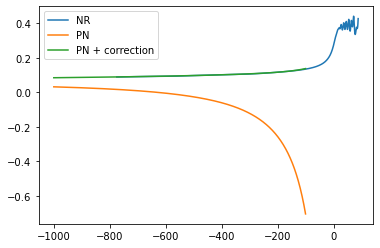

In [410]:
plt.plot(nr_times, freq, label='NR')
plt.plot(t, omega_pn_, label='PN')
plt.plot(t, omega_pn_ + (omega_N_*cm.predict(t)), label='PN + correction')
plt.legend()

(0.0, 0.2)

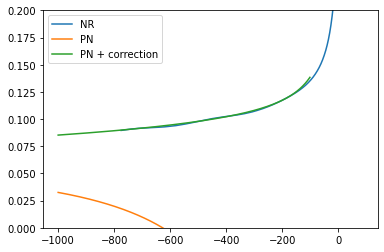

In [411]:
plt.plot(nr_times, freq, label='NR')
plt.plot(t, omega_pn_, label='PN')
plt.plot(t, omega_pn_ + (omega_N_*cm.predict(t)), label='PN + correction')
plt.legend()
plt.ylim(0, 0.2)

In [412]:
# model
GW22AngFreq=omega_pn_ + (omega_N_*cm.predict(t))

In [413]:
x_ = pn.x_from_omega_22(GW22AngFreq)
Hhat22_ = pn.Hhat22_x(x_, eta)
Hhat22_ = np.abs(Hhat22_)

In [414]:
Hhat22_raw_pn = pn.TaylorT3_Hhat22(t, tc, eta, M)
Hhat22_raw_pn = np.abs(Hhat22_raw_pn)

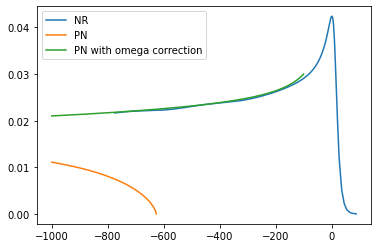

In [415]:
plt.plot(nr_times, amp, label='NR')
plt.plot(t, Hhat22_raw_pn, label='PN')
plt.plot(t, Hhat22_, label='PN with omega correction')
plt.legend()

In [416]:
# here we see that Raw PN (orange) becomes negative because the PN
# frequency breaks down and becomes negative
# which means (omega)^(2/3) becomes complex

# we can fix this by first fitting a correction to the
# PN frequency and using this to compute the amplitude

In [417]:
Hhat22_pre = pn.Hhat22_pre_factor(x_, eta)

In [418]:
# interpolate onto common grid
common_times_start = max(nr_times[0], t[0])
common_times_end = min(nr_times[-1], t[-1])
common_times = np.arange(common_times_start, common_times_end, 1)

nr_amp_ = IUS(nr_times, amp)(common_times)
pn_amp_ = IUS(t, Hhat22_)(common_times)
pn_amp_pre_ = IUS(t, Hhat22_pre)(common_times)

Text(0.5, 1.0, 'NR and PN on same grid')

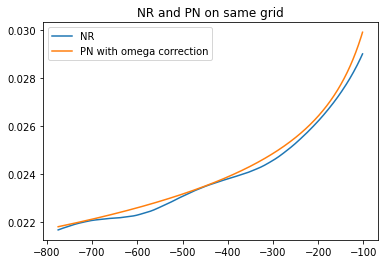

In [419]:
plt.plot(common_times, nr_amp_, label='NR')
plt.plot(common_times, pn_amp_, label='PN with omega correction')
plt.legend()
plt.title("NR and PN on same grid")

Text(0.5, 1.0, 'factor out leading order PN')

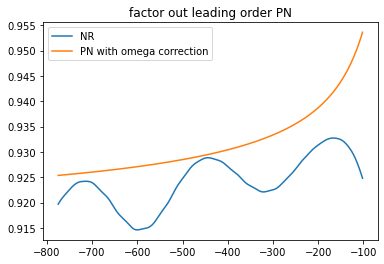

In [420]:
plt.plot(common_times, nr_amp_/pn_amp_pre_, label='NR')
plt.plot(common_times, pn_amp_/pn_amp_pre_, label='PN with omega correction')
plt.legend()
plt.title("factor out leading order PN")